# This project is to analyse and create a solution to detect sentiments in Audio files. The publicly available data set is used to train the model. CNN is used to train here. Keras is used to build the Actual Model

#### Importing the required libraries

In [71]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn import metrics
from sklearn.model_selection import train_test_split  
from sklearn.tree import DecisionTreeClassifier  
from sklearn.metrics import classification_report, confusion_matrix  
from sklearn.externals.six import StringIO  
from IPython.display import Image  
import graphviz 
from sklearn.tree import export_graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC 
import pydotplus
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
plt.style.use('bmh')
import librosa ## This is the library for the Audio analysis of files
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib.pyplot import specgram
import keras
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix
from keras import regularizers
import os
import pandas as pd
import librosa
import glob 
import matplotlib.pyplot as plt
import scipy.io.wavfile
import numpy as np
import sys
import soundfile as sf
from scipy.io import wavfile

#### Load all the raw data here

#### The dataset is The Ryerson Audio-Visual Database of Emotional Speech and Song (RAVDESS)

In [80]:
# Dataset link is here: https://zenodo.org/record/1188976#.XHSDopP7SRt

In [12]:
mylist= os.listdir('RawData/')

In [44]:
type(mylist)

list

In [45]:
len(mylist)

1012

In [15]:
print(mylist[180])

03-02-06-02-01-02-01.wav


In [16]:
print(mylist[400][6:-16])

02


## Plotting the audio file's waveform and its spectrogram

In [18]:
data, sampling_rate = librosa.load('RawData/03-02-01-01-01-01-01.wav')

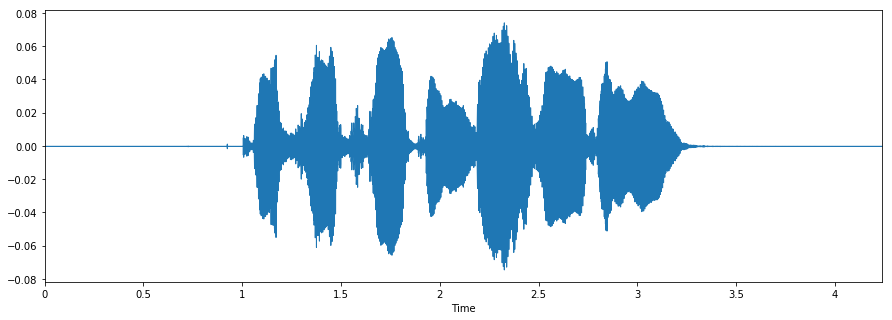

In [20]:
#% pylab inline
plt.figure(figsize=(15, 5))
librosa.display.waveplot(data, sr=sampling_rate)

/Users/vaibhavverdhan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log


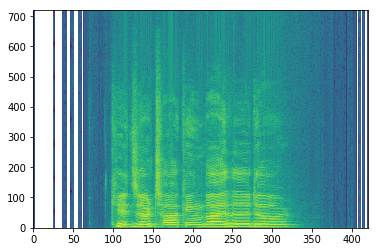

In [22]:
sr,x = scipy.io.wavfile.read('RawData/03-02-01-01-01-01-01.wav')

## Parameters: 10ms step, 30ms window
nstep = int(sr * 0.01)
nwin  = int(sr * 0.03)
nfft = nwin

window = np.hamming(nwin)

## will take windows x[n1:n2].  generate
## and loop over n2 such that all frames
## fit within the waveform
nn = range(nwin, len(x), nstep)

X = np.zeros( (len(nn), nfft//2) )

for i,n in enumerate(nn):
    xseg = x[n-nwin:n]
    z = np.fft.fft(window * xseg, nfft)
    X[i,:] = np.log(np.abs(z[:nfft//2]))

plt.imshow(X.T, interpolation='nearest',
    origin='lower',
    aspect='auto')

plt.show()

## Setting the labels

In [13]:
feeling_list=[]
for item in mylist:
    if item[6:-16]=='02' and int(item[18:-4])%2==0:
        feeling_list.append('female_calm')
    elif item[6:-16]=='02' and int(item[18:-4])%2==1:
        feeling_list.append('male_calm')
    elif item[6:-16]=='03' and int(item[18:-4])%2==0:
        feeling_list.append('female_happy')
    elif item[6:-16]=='03' and int(item[18:-4])%2==1:
        feeling_list.append('male_happy')
    elif item[6:-16]=='04' and int(item[18:-4])%2==0:
        feeling_list.append('female_sad')
    elif item[6:-16]=='04' and int(item[18:-4])%2==1:
        feeling_list.append('male_sad')
    elif item[6:-16]=='05' and int(item[18:-4])%2==0:
        feeling_list.append('female_angry')
    elif item[6:-16]=='05' and int(item[18:-4])%2==1:
        feeling_list.append('male_angry')
    elif item[6:-16]=='06' and int(item[18:-4])%2==0:
        feeling_list.append('female_fearful')
    elif item[6:-16]=='06' and int(item[18:-4])%2==1:
        feeling_list.append('male_fearful')
    elif item[:1]=='a':
        feeling_list.append('male_angry')
    elif item[:1]=='f':
        feeling_list.append('male_fearful')
    elif item[:1]=='h':
        feeling_list.append('male_happy')
    elif item[:1]=='n':
        feeling_list.append('neutral')
    elif item[:2]=='sa':
        feeling_list.append('male_sad')

In [14]:
labels = pd.DataFrame(feeling_list)

In [15]:
labels.columns = ['emotions']

In [16]:
labels.apply(pd.value_counts)

,emotions
male_sad,96
male_calm,96
male_fearful,96
male_happy,96
male_angry,96
female_fearful,88
female_happy,88
female_angry,88
female_calm,88
female_sad,88


## Getting the features of audio files using librosa

In [17]:
df = pd.DataFrame(columns=['feature'])
bookmark=0
for index,y in enumerate(mylist):
    if mylist[index][6:-16]!='01' and mylist[index][6:-16]!='07' and mylist[index][6:-16]!='08' and mylist[index][:2]!='su' and mylist[index][:1]!='n' and mylist[index][:1]!='d':
        X, sample_rate = librosa.load('RawData/'+y, res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)
        sample_rate = np.array(sample_rate)
        mfccs = np.mean(librosa.feature.mfcc(y=X, 
                                            sr=sample_rate, 
                                            n_mfcc=13),
                        axis=0)
        feature = mfccs
        df.loc[bookmark] = [feature]
        bookmark=bookmark+1        

In [18]:
df.shape

(920, 1)

In [19]:
df[:5]

,feature
0,"[-55.677100041008956, -55.42473315532577, -55...."
1,"[-49.55359492900165, -47.61808514016757, -47.4..."
2,"[-49.125367197674514, -49.125367197674514, -49..."
3,"[-48.357218354719016, -49.43028284992086, -50...."
4,"[-59.4927280795203, -57.43862499743045, -58.02..."


In [20]:
df3 = pd.DataFrame(df['feature'].values.tolist())

df3[:5]

In [21]:
newdf = pd.concat([df3,labels], axis=1)

In [22]:
newdf.head()

,0,1,2,3,4,5,6,7,8,9,...,207,208,209,210,211,212,213,214,215,emotions
0,-55.677100,-55.424733,-55.242881,-54.337877,-51.845705,-50.900707,-51.864141,-53.123499,-51.652347,-52.188430,...,-36.282608,-37.351995,-36.989072,-36.189186,-38.254011,-42.123516,-41.551518,-19.894625,-10.708131,female_happy
1,-49.553595,-47.618085,-47.406584,-48.722094,-50.155449,-49.913823,-50.302380,-49.820660,-48.415183,-47.448050,...,-41.037263,-40.217180,-41.344359,-40.102269,-41.549201,-40.855933,-41.655109,-33.537083,-24.817997,female_happy
2,-49.125367,-49.125367,-49.125367,-49.125367,-49.125367,-49.125367,-49.125367,-49.125367,-49.125367,-49.125367,...,-40.075873,-40.382621,-41.422292,-41.323493,-40.875008,-42.256476,-42.060937,-28.257272,-21.191413,female_sad
3,-48.357218,-49.430283,-50.111182,-50.486868,-51.137060,-52.242590,-52.619966,-53.342678,-55.513903,-54.593997,...,-53.471345,-53.100919,-52.832289,-52.023308,-51.293833,-50.672554,-50.069527,-40.041285,-33.815947,female_sad
4,-59.492728,-57.438625,-58.028568,-58.126133,-56.886299,-55.768754,-53.635292,-52.301717,-50.814459,-50.483752,...,-46.910592,-47.040974,-48.570025,-49.678281,-48.496414,-49.013574,-49.344328,-47.388026,-42.105581,female_sad


In [23]:
newdf.to_csv("DataSet_First.csv")

#### Prepare the dataset here. We have to incorporate new features here

In [24]:
#Detection of amplitude here

In [75]:
amplitude_array = []
for index,y in enumerate(mylist):
    
    if mylist[index][6:-16]!='01' and mylist[index][6:-16]!='07' and mylist[index][6:-16]!='08' and mylist[index][:2]!='su' and mylist[index][:1]!='n' and mylist[index][:1]!='d':
        audio = 'RawData/'+mylist[index]
        amplitude, samplerate = sf.read(audio)
        
        amp_final = amplitude.mean()
        amplitude_array.append(amp_final)
        
        

In [76]:
len(amplitude_array)

920

In [77]:
type(amplitude_array)

list

In [78]:
amplitude_array[10]

-1.3744455730539715e-05

In [64]:
amplitude_df = pd.DataFrame({'Amp1':amplitude_array})

In [65]:
amplitude_df.head()

,Amp1
0,2.429984e-06
1,8.454690e-07
2,2.485711e-05
3,2.442117e-06
4,-4.566747e-07


In [67]:
amplitude_df.shape

(920, 1)

In [68]:
amplitude_df.to_csv('Amplitude.csv')

In [ ]:
#Detect Pitch here

In [90]:
pitch_array = []
for index,y in enumerate(mylist):
    
    if mylist[index][6:-16]!='01' and mylist[index][6:-16]!='07' and mylist[index][6:-16]!='08' and mylist[index][:2]!='su' and mylist[index][:1]!='n' and mylist[index][:1]!='d':
        audio = 'RawData/'+mylist[index]
        #print(audio)
        try:
            samplerate, pitch = wavfile.read(audio)
            pitch_final = pitch.mean()
        except:
            pitch_final = 0

        
        pitch_array.append(pitch_final)
        
        

In [91]:
len(pitch_array)

920

In [92]:
type(pitch_array)

list

In [93]:
pitch_df = pd.DataFrame({'Pitch':pitch_array})

In [94]:
pitch_df.head()

,Pitch
0,0.079626
1,0.000000
2,0.000000
3,0.080023
4,0.000000


In [95]:
pitch_df.to_csv('Pitch.csv')

# Modelling Starts from here

In [96]:
newdf = pd.read_csv('DataSet_Processed.csv')

In [97]:
independent_var = newdf.drop('emotions', axis=1)  

In [98]:
target_var = newdf['emotions']  

In [99]:
X_train, X_test, y_train, y_test = train_test_split(independent_var, target_var, test_size=0.20)  

#### Decision Tree Implementation Here

In [100]:
classifier = DecisionTreeClassifier()  

In [101]:
classifier.fit(X_train, y_train)  

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [102]:
y_pred_train = classifier.predict(X_train)  

In [103]:
print(confusion_matrix(y_train, y_pred_train))  

[[72  0  0  0  0  0  0  0  0  0]
 [ 0 63  0  0  0  0  0  0  0  0]
 [ 0  0 70  0  0  0  0  0  0  0]
 [ 0  0  0 73  0  0  0  0  0  0]
 [ 0  0  0  0 74  0  0  0  0  0]
 [ 0  0  0  0  0 76  0  0  0  0]
 [ 0  0  0  0  0  0 80  0  0  0]
 [ 0  0  0  0  0  0  0 76  0  0]
 [ 0  0  0  0  0  0  0  0 78  0]
 [ 0  0  0  0  0  0  0  0  0 74]]


In [104]:
accuracy = accuracy_score(y_train, y_pred_train)
accuracy

1.0

In [105]:
y_pred_test = classifier.predict(X_test)  

In [106]:
print(confusion_matrix(y_test, y_pred_test))  

[[ 6  0  4  3  0  0  0  0  0  3]
 [ 0 12  4  5  4  0  0  0  0  0]
 [ 4  0  6  5  2  0  0  0  1  0]
 [ 2  0  4  6  2  0  0  0  0  1]
 [ 0  7  2  0  5  0  0  0  0  0]
 [ 0  0  0  0  0  9  2  3  4  2]
 [ 0  0  0  0  0  2  5  1  3  5]
 [ 0  0  0  0  0  6  2  5  5  2]
 [ 2  0  0  0  0  4  0  2 10  0]
 [ 1  0  2  0  0  2  6  2  2  7]]


In [107]:
print(classification_report(y_test, y_pred_test))  

                precision    recall  f1-score   support

  female_angry       0.40      0.38      0.39        16
   female_calm       0.63      0.48      0.55        25
female_fearful       0.27      0.33      0.30        18
  female_happy       0.32      0.40      0.35        15
    female_sad       0.38      0.36      0.37        14
    male_angry       0.39      0.45      0.42        20
     male_calm       0.33      0.31      0.32        16
  male_fearful       0.38      0.25      0.30        20
    male_happy       0.40      0.56      0.47        18
      male_sad       0.35      0.32      0.33        22

     micro avg       0.39      0.39      0.39       184
     macro avg       0.39      0.38      0.38       184
  weighted avg       0.40      0.39      0.39       184



In [108]:
accuracy = accuracy_score(y_test, y_pred_test)
accuracy

0.3858695652173913

#### Random Forest

In [109]:
rf_classifier = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 42)
rf_classifier.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [110]:
y_pred_train = rf_classifier.predict(X_train)  
print(classification_report(y_train, y_pred_train))  
accuracy = accuracy_score(y_train, y_pred_train)
accuracy

                precision    recall  f1-score   support

  female_angry       1.00      1.00      1.00        72
   female_calm       0.95      1.00      0.98        63
female_fearful       0.97      1.00      0.99        70
  female_happy       1.00      0.97      0.99        73
    female_sad       1.00      0.96      0.98        74
    male_angry       1.00      1.00      1.00        76
     male_calm       1.00      1.00      1.00        80
  male_fearful       1.00      0.99      0.99        76
    male_happy       0.99      1.00      0.99        78
      male_sad       1.00      1.00      1.00        74

     micro avg       0.99      0.99      0.99       736
     macro avg       0.99      0.99      0.99       736
  weighted avg       0.99      0.99      0.99       736



0.9918478260869565

In [111]:
y_pred_test = rf_classifier.predict(X_test)  
print(classification_report(y_test, y_pred_test))  
accuracy = accuracy_score(y_test, y_pred_test)
accuracy

                precision    recall  f1-score   support

  female_angry       0.40      0.62      0.49        16
   female_calm       0.67      0.40      0.50        25
female_fearful       0.57      0.44      0.50        18
  female_happy       0.37      0.47      0.41        15
    female_sad       0.35      0.43      0.39        14
    male_angry       0.63      0.60      0.62        20
     male_calm       0.31      0.50      0.38        16
  male_fearful       0.57      0.40      0.47        20
    male_happy       0.35      0.44      0.39        18
      male_sad       0.42      0.23      0.29        22

     micro avg       0.45      0.45      0.45       184
     macro avg       0.46      0.45      0.44       184
  weighted avg       0.48      0.45      0.45       184



0.44565217391304346

#### Support Vector Machine Implementation

In [112]:
svm_model = SVC(kernel = 'linear', C = 1).fit(X_train, y_train)

In [113]:
y_pred_train = svm_model.predict(X_train)  
print(classification_report(y_train, y_pred_train))  
accuracy = accuracy_score(y_train, y_pred_train)
accuracy

                precision    recall  f1-score   support

  female_angry       1.00      1.00      1.00        72
   female_calm       1.00      1.00      1.00        63
female_fearful       1.00      1.00      1.00        70
  female_happy       1.00      1.00      1.00        73
    female_sad       1.00      1.00      1.00        74
    male_angry       1.00      1.00      1.00        76
     male_calm       1.00      1.00      1.00        80
  male_fearful       1.00      1.00      1.00        76
    male_happy       1.00      1.00      1.00        78
      male_sad       1.00      1.00      1.00        74

     micro avg       1.00      1.00      1.00       736
     macro avg       1.00      1.00      1.00       736
  weighted avg       1.00      1.00      1.00       736



1.0

In [114]:
y_pred_test = svm_model.predict(X_test)  
print(classification_report(y_test, y_pred_test))  
accuracy = accuracy_score(y_test, y_pred_test)
accuracy

                precision    recall  f1-score   support

  female_angry       0.43      0.62      0.51        16
   female_calm       0.61      0.44      0.51        25
female_fearful       0.46      0.61      0.52        18
  female_happy       0.33      0.27      0.30        15
    female_sad       0.25      0.21      0.23        14
    male_angry       0.43      0.60      0.50        20
     male_calm       0.33      0.44      0.38        16
  male_fearful       0.39      0.35      0.37        20
    male_happy       0.40      0.33      0.36        18
      male_sad       0.54      0.32      0.40        22

     micro avg       0.42      0.42      0.42       184
     macro avg       0.42      0.42      0.41       184
  weighted avg       0.43      0.42      0.42       184



0.42391304347826086

#### Naive Bayes Classifier Implementation

In [115]:
gnb_model = GaussianNB().fit(X_train, y_train) 

In [116]:
y_pred_train = gnb_model.predict(X_train)  
print(classification_report(y_train, y_pred_train))  
accuracy = accuracy_score(y_train, y_pred_train)
accuracy

                precision    recall  f1-score   support

  female_angry       0.56      0.64      0.60        72
   female_calm       0.49      0.79      0.61        63
female_fearful       0.52      0.23      0.32        70
  female_happy       0.44      0.53      0.48        73
    female_sad       0.37      0.31      0.34        74
    male_angry       0.51      0.71      0.60        76
     male_calm       0.39      0.55      0.46        80
  male_fearful       0.39      0.12      0.18        76
    male_happy       0.31      0.51      0.39        78
      male_sad       0.00      0.00      0.00        74

     micro avg       0.44      0.44      0.44       736
     macro avg       0.40      0.44      0.40       736
  weighted avg       0.40      0.44      0.39       736



0.4361413043478261

In [117]:
y_pred_test = gnb_model.predict(X_test)  
print(classification_report(y_test, y_pred_test))  
accuracy = accuracy_score(y_test, y_pred_test)
accuracy

                precision    recall  f1-score   support

  female_angry       0.35      0.44      0.39        16
   female_calm       0.67      0.64      0.65        25
female_fearful       0.33      0.17      0.22        18
  female_happy       0.28      0.53      0.36        15
    female_sad       0.50      0.29      0.36        14
    male_angry       0.52      0.65      0.58        20
     male_calm       0.28      0.50      0.36        16
  male_fearful       0.33      0.15      0.21        20
    male_happy       0.29      0.44      0.35        18
      male_sad       0.00      0.00      0.00        22

     micro avg       0.38      0.38      0.38       184
     macro avg       0.35      0.38      0.35       184
  weighted avg       0.36      0.38      0.35       184



0.3804347826086957

# Neural Net Model Starts here

In [118]:
rnewdf = newdf.rename(index=str, columns={"0": "label"})

In [119]:
rnewdf[:5]

,Unnamed: 0,label,1,2,3,4,5,6,7,8,...,212,213,214,215,Mean,STDEV,MEDIAN,Amplitude,Pitch,emotions
0,0,-55.677100,-55.424733,-55.242881,-54.337877,-51.845705,-50.900707,-51.864141,-53.123499,-51.652347,...,-42.123516,-41.551518,-19.894625,-10.708131,-39.403661,7.194679,-38.255094,2.430000e-06,0.079626,female_happy
1,1,-49.553595,-47.618085,-47.406584,-48.722094,-50.155449,-49.913823,-50.302380,-49.820660,-48.415183,...,-40.855933,-41.655109,-33.537083,-24.817997,-41.757136,4.107069,-41.612957,8.450000e-07,0.000000,female_happy
2,2,-49.125367,-49.125367,-49.125367,-49.125367,-49.125367,-49.125367,-49.125367,-49.125367,-49.125367,...,-42.256476,-42.060937,-28.257272,-21.191413,-41.649079,5.337700,-41.135304,2.490000e-05,0.000000,female_sad
3,3,-48.357218,-49.430283,-50.111182,-50.486868,-51.137060,-52.242590,-52.619966,-53.342678,-55.513903,...,-50.672554,-50.069527,-40.041285,-33.815947,-48.362892,6.127473,-48.829685,2.440000e-06,0.080023,female_sad
4,4,-59.492728,-57.438625,-58.028568,-58.126133,-56.886299,-55.768754,-53.635292,-52.301717,-50.814459,...,-49.013574,-49.344328,-47.388026,-42.105581,-49.695395,5.050245,-49.297148,-4.570000e-07,0.000000,female_sad


In [120]:
from sklearn.utils import shuffle
rnewdf = shuffle(newdf)
rnewdf[:10]

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,212,213,214,215,Mean,STDEV,MEDIAN,Amplitude,Pitch,emotions
836,836,-55.036996,-53.557774,-52.267947,-49.682951,-53.053395,-54.894633,-53.467181,-51.356150,-53.419991,...,-33.358526,-33.725561,-30.821615,-26.456878,-34.334672,10.428043,-30.309340,-2.710000e-07,-0.008893,male_calm
246,246,-55.303079,-55.303079,-55.303079,-55.303079,-55.303079,-55.303079,-55.303079,-55.303079,-55.303079,...,-40.494921,-41.467944,-38.082316,-33.648341,-41.979244,8.282869,-40.495772,-1.720000e-06,-0.056503,female_angry
736,736,-53.067319,-52.865178,-52.371987,-51.687556,-50.528613,-48.591673,-48.132655,-49.484480,-51.681517,...,-36.681119,-36.479218,-22.334848,-14.097554,-40.941059,5.722359,-39.766586,9.060000e-07,0.029689,female_happy
297,297,-46.440618,-48.289772,-48.639488,-49.097006,-48.836427,-47.361496,-46.797548,-47.487101,-48.186247,...,-21.465983,-23.119274,-16.448596,-12.831796,-24.549540,11.589675,-20.458465,-7.890000e-05,-2.586236,male_sad
811,811,-46.592186,-45.763639,-45.857073,-46.197030,-46.206998,-46.273869,-46.628709,-46.783703,-47.239882,...,-25.506923,-24.132412,-18.201854,-16.014590,-27.420088,8.469284,-24.600378,-7.290000e-06,0.000000,male_happy
204,204,-47.821828,-48.635085,-46.820762,-45.247693,-45.690394,-47.105988,-46.005597,-44.964468,-45.962769,...,-35.859240,-38.085452,-25.320959,-17.375387,-42.669955,5.466899,-42.056388,1.360000e-06,0.044632,female_fearful
194,194,-50.080288,-51.960425,-52.676604,-53.054458,-53.789648,-53.789648,-52.981400,-51.868303,-49.291393,...,-25.267454,-25.456305,-19.606701,-15.558041,-29.614682,11.270676,-26.784122,-2.130000e-05,0.000000,male_fearful
262,262,-53.865381,-53.822882,-53.105777,-50.707287,-50.523971,-50.977950,-51.374279,-52.872238,-54.247399,...,-24.431613,-25.276547,-13.611707,-7.174174,-30.666463,11.284863,-25.985446,1.030000e-06,0.033712,male_fearful
419,419,-52.608081,-49.516917,-50.374349,-53.096920,-52.763952,-50.902693,-49.895931,-47.445260,-47.316086,...,-26.327814,-25.804108,-19.461020,-14.189299,-27.436676,9.670372,-24.270692,4.370000e-06,0.143040,male_angry
708,708,-48.954499,-48.828615,-49.681607,-52.032167,-48.399128,-47.975902,-49.650617,-51.260967,-49.758039,...,-27.322341,-28.557564,-28.592688,-25.435740,-29.678529,10.425756,-25.786166,-6.460000e-06,0.000000,male_calm


In [121]:
rnewdf=rnewdf.fillna(0)

#### Dividing the data into test and train

In [122]:
newdf1 = np.random.rand(len(rnewdf)) < 0.8
train = rnewdf[newdf1]
test = rnewdf[~newdf1]

In [123]:
train[250:260]

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,212,213,214,215,Mean,STDEV,MEDIAN,Amplitude,Pitch,emotions
285,285,-59.062208,-60.086138,-58.531598,-57.556338,-58.143630,-58.897322,-58.728392,-56.580152,-55.314581,...,-41.994367,-44.686715,-45.026515,-43.307993,-37.491838,9.293874,-33.549611,-1.430000e-08,0.000000,male_sad
102,102,-62.299694,-62.338424,-62.621848,-62.329484,-61.454263,-61.094933,-61.070457,-61.927559,-61.730643,...,-46.662255,-48.665217,-36.969883,-29.968863,-50.220380,6.494198,-48.025176,-4.150000e-07,0.000000,female_sad
858,858,-55.024892,-55.320724,-55.467604,-55.037523,-55.808058,-54.765509,-48.205385,-45.122785,-43.965091,...,-30.893080,-33.106905,-27.414908,-19.476549,-39.424471,5.703604,-39.139686,-5.530000e-07,0.000000,female_happy
510,510,-42.376237,-42.376237,-42.376237,-42.376237,-42.376237,-42.376237,-42.376237,-42.376237,-42.376237,...,-27.977144,-27.112395,-17.806685,-9.232742,-33.137611,6.923744,-33.534857,2.990000e-06,0.000000,female_angry
170,170,-60.975161,-60.975161,-60.975161,-60.975161,-60.975161,-60.975161,-60.975161,-60.975161,-60.975161,...,-36.094180,-35.166264,-34.432567,-31.169479,-38.641755,11.694423,-33.888191,2.200000e-07,0.007220,male_sad
489,489,-37.625122,-36.502180,-36.284159,-35.003262,-35.008088,-33.986679,-34.470556,-35.709850,-36.329798,...,-14.192994,-13.168046,-13.368124,-9.639316,-26.858449,8.901870,-23.811135,3.740000e-06,0.000000,male_angry
410,410,-48.106941,-49.158665,-48.997037,-49.030410,-47.889787,-47.993323,-47.575151,-47.450629,-45.704175,...,-41.167236,-43.128977,-41.901056,-38.005526,-29.474535,7.437532,-27.041644,1.200000e-06,0.039424,male_fearful
367,367,-51.967466,-51.584417,-51.798072,-52.369677,-51.502517,-51.277643,-50.542725,-49.925582,-49.461802,...,-47.952118,-47.559419,-28.053577,-19.832642,-43.000281,6.706607,-42.254596,-1.520000e-06,-0.049765,female_angry
629,629,-60.545437,-60.550970,-60.479632,-60.441140,-60.441140,-60.441140,-60.460615,-60.449480,-60.441140,...,-47.712504,-47.323891,-48.837520,-49.169343,-52.928183,4.496911,-51.831870,1.460000e-07,0.000000,female_sad
788,788,-53.103365,-50.430790,-49.572004,-51.374546,-51.453958,-50.243284,-51.032887,-51.047478,-49.950050,...,-26.044962,-26.149800,-22.654567,-20.414156,-30.632020,9.816620,-26.779569,1.480000e-07,0.004845,male_happy


In [124]:
trainfeatures = train.iloc[:, :-1]

In [125]:
trainlabel = train.iloc[:, -1:]

In [126]:
testfeatures = test.iloc[:, :-1]

In [127]:
testlabel = test.iloc[:, -1:]

In [128]:
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder

X_train = np.array(trainfeatures)
y_train = np.array(trainlabel)
X_test = np.array(testfeatures)
y_test = np.array(testlabel)

lb = LabelEncoder()

y_train = np_utils.to_categorical(lb.fit_transform(y_train))
y_test = np_utils.to_categorical(lb.fit_transform(y_test))


In [129]:
y_train

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]], dtype=float32)

In [130]:
X_train.shape

(727, 222)

In [132]:
X_train[0]

array([ 2.46000000e+02, -5.53030786e+01, -5.53030786e+01, -5.53030786e+01,
       -5.53030786e+01, -5.53030786e+01, -5.53030786e+01, -5.53030786e+01,
       -5.53030786e+01, -5.53030786e+01, -5.53030786e+01, -5.53030786e+01,
       -5.53030786e+01, -5.53030786e+01, -5.53030786e+01, -5.53030786e+01,
       -5.53030786e+01, -5.53030786e+01, -5.53030786e+01, -5.53030786e+01,
       -5.53030786e+01, -5.53030786e+01, -5.53030786e+01, -5.53030786e+01,
       -5.53030786e+01, -5.53030786e+01, -5.53030786e+01, -5.53030786e+01,
       -5.53030786e+01, -5.53030786e+01, -5.53030786e+01, -5.53030786e+01,
       -5.53030786e+01, -5.53030786e+01, -5.53030786e+01, -5.53030786e+01,
       -5.53030786e+01, -5.53030786e+01, -5.53030786e+01, -5.53030786e+01,
       -5.53030786e+01, -5.53030786e+01, -5.53030786e+01, -5.53030786e+01,
       -5.53030786e+01, -5.53030786e+01, -5.51045879e+01, -4.86004390e+01,
       -3.71342385e+01, -3.53678584e+01, -3.35389611e+01, -3.25654119e+01,
       -3.35485627e+01, -

## Changing dimension for CNN model

In [133]:

x_traincnn =np.expand_dims(X_train, axis=2)
x_testcnn= np.expand_dims(X_test, axis=2)

#### Testing by creation of various models is done here

In [183]:
model = Sequential()

model.add(Conv1D(256, 5,padding='same',
                 input_shape=(216,1)))
model.add(Activation('relu'))
model.add(Conv1D(128, 5,padding='same'))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
model.add(Flatten())
model.add(Dense(10))
model.add(Activation('softmax'))
opt = keras.optimizers.rmsprop(lr=0.00001, decay=1e-6)

In [184]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_33 (Conv1D)           (None, 216, 256)          1536      
_________________________________________________________________
activation_39 (Activation)   (None, 216, 256)          0         
_________________________________________________________________
conv1d_34 (Conv1D)           (None, 216, 128)          163968    
_________________________________________________________________
activation_40 (Activation)   (None, 216, 128)          0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 216, 128)          0         
_________________________________________________________________
max_pooling1d_7 (MaxPooling1 (None, 27, 128)           0         
_________________________________________________________________
conv1d_35 (Conv1D)           (None, 27, 128)           82048     
__________

In [185]:
model.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])

### Another try, here we tried at least 12-15 iterations

In [193]:
cnnhistory=model.fit(x_traincnn, y_train, batch_size=84, epochs=200, validation_data=(x_testcnn, y_test))

Train on 746 samples, validate on 174 samples
Epoch 1/200
746/746 [==============================] - 2s 2ms/step - loss: 0.6092 - acc: 0.7815 - val_loss: 1.2570 - val_acc: 0.5000
Epoch 2/200
746/746 [==============================] - 2s 2ms/step - loss: 0.6080 - acc: 0.7828 - val_loss: 1.2425 - val_acc: 0.5115
Epoch 3/200
746/746 [==============================] - 2s 2ms/step - loss: 0.5857 - acc: 0.7761 - val_loss: 1.2883 - val_acc: 0.5000
Epoch 4/200
746/746 [==============================] - 2s 2ms/step - loss: 0.6264 - acc: 0.7748 - val_loss: 1.2734 - val_acc: 0.5172
Epoch 5/200
746/746 [==============================] - 2s 2ms/step - loss: 0.5954 - acc: 0.7775 - val_loss: 1.2433 - val_acc: 0.5172
Epoch 6/200
746/746 [==============================] - 2s 3ms/step - loss: 0.5973 - acc: 0.7882 - val_loss: 1.2373 - val_acc: 0.5172
Epoch 7/200
746/746 [==============================] - 2s 3ms/step - loss: 0.6005 - acc: 0.7815 - val_loss: 1.2934 - val_acc: 0.5172
Epoch 8/200
746/746 [==

Epoch 62/200
746/746 [==============================] - 2s 3ms/step - loss: 0.5566 - acc: 0.7989 - val_loss: 1.3131 - val_acc: 0.5057
Epoch 63/200
746/746 [==============================] - 2s 3ms/step - loss: 0.5498 - acc: 0.7895 - val_loss: 1.2598 - val_acc: 0.5115
Epoch 64/200
746/746 [==============================] - 2s 3ms/step - loss: 0.5620 - acc: 0.7895 - val_loss: 1.2820 - val_acc: 0.5000
Epoch 65/200
746/746 [==============================] - 2s 2ms/step - loss: 0.5682 - acc: 0.8097 - val_loss: 1.2825 - val_acc: 0.4828
Epoch 66/200
746/746 [==============================] - 2s 3ms/step - loss: 0.5833 - acc: 0.7828 - val_loss: 1.2778 - val_acc: 0.5000
Epoch 67/200
746/746 [==============================] - 2s 3ms/step - loss: 0.5569 - acc: 0.7855 - val_loss: 1.2813 - val_acc: 0.4885
Epoch 68/200
746/746 [==============================] - 2s 2ms/step - loss: 0.5746 - acc: 0.7895 - val_loss: 1.2633 - val_acc: 0.5115
Epoch 69/200
746/746 [==============================] - 2s 3ms

Epoch 123/200
746/746 [==============================] - 2s 2ms/step - loss: 0.5170 - acc: 0.7936 - val_loss: 1.2936 - val_acc: 0.5115
Epoch 124/200
746/746 [==============================] - 2s 2ms/step - loss: 0.5022 - acc: 0.8123 - val_loss: 1.3122 - val_acc: 0.5000
Epoch 125/200
746/746 [==============================] - 2s 2ms/step - loss: 0.5240 - acc: 0.8003 - val_loss: 1.3255 - val_acc: 0.5230
Epoch 126/200
746/746 [==============================] - 2s 3ms/step - loss: 0.5112 - acc: 0.8284 - val_loss: 1.2872 - val_acc: 0.5115
Epoch 127/200
746/746 [==============================] - 2s 2ms/step - loss: 0.5147 - acc: 0.8043 - val_loss: 1.3523 - val_acc: 0.5115
Epoch 128/200
746/746 [==============================] - 2s 2ms/step - loss: 0.5255 - acc: 0.8164 - val_loss: 1.3237 - val_acc: 0.4943
Epoch 129/200
746/746 [==============================] - 2s 2ms/step - loss: 0.5000 - acc: 0.8351 - val_loss: 1.2960 - val_acc: 0.5057
Epoch 130/200
746/746 [==============================] 

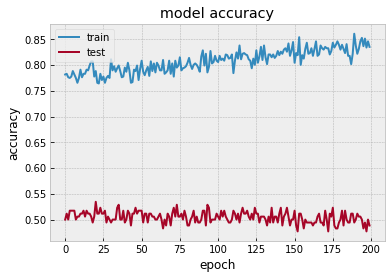

In [194]:
plt.plot(cnnhistory.history['acc'])
plt.plot(cnnhistory.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [195]:
model_name = 'Emotion_Voice_Detection_Model1.h5'
save_dir = os.path.join(os.getcwd(), 'saved_models')
# Save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

Saved trained model at /Users/vaibhavverdhan/Capabilities/Speech-Emotion-Analyzer-master/saved_models/Emotion_Voice_Detection_Model1.h5 


In [196]:
import json
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

In [197]:
# loading json and creating model
from keras.models import model_from_json
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("saved_models/Emotion_Voice_Detection_Model1.h5")
print("Loaded model from disk")
 
# evaluate loaded model on test data
loaded_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
score = loaded_model.evaluate(x_testcnn, y_test, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

Loaded model from disk
acc: 48.85%


In [218]:
# checkpoint
filepath="weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

cnnhistory=model.fit(x_traincnn, y_train, batch_size=32, epochs=10, validation_data=(x_testcnn, y_test), callbacks=callbacks_list, verbose=0)


Epoch 00001: val_acc improved from -inf to 0.47701, saving model to weights.best.hdf5

Epoch 00002: val_acc did not improve from 0.47701

Epoch 00003: val_acc improved from 0.47701 to 0.49425, saving model to weights.best.hdf5

Epoch 00004: val_acc did not improve from 0.49425

Epoch 00005: val_acc improved from 0.49425 to 0.50000, saving model to weights.best.hdf5

Epoch 00006: val_acc did not improve from 0.50000

Epoch 00007: val_acc improved from 0.50000 to 0.50575, saving model to weights.best.hdf5

Epoch 00008: val_acc did not improve from 0.50575

Epoch 00009: val_acc did not improve from 0.50575

Epoch 00010: val_acc did not improve from 0.50575


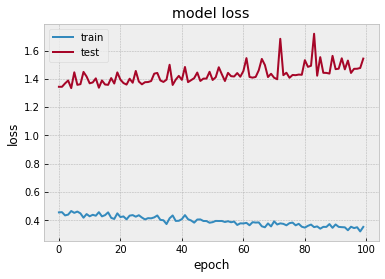

In [201]:
plt.plot(cnnhistory.history['loss'])
plt.plot(cnnhistory.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# This is the Final Model 

In [138]:
model = Sequential()

model.add(Conv1D(128, 5,padding='same',
                 input_shape=(222,1)))
model.add(Activation('relu'))
model.add(Conv1D(128, 5,padding='same'))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
model.add(Flatten())
model.add(Dense(10))
model.add(Activation('softmax'))
opt = keras.optimizers.rmsprop(lr=0.00001, decay=1e-6)

In [139]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_7 (Conv1D)            (None, 222, 128)          768       
_________________________________________________________________
activation_8 (Activation)    (None, 222, 128)          0         
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 222, 128)          82048     
_________________________________________________________________
activation_9 (Activation)    (None, 222, 128)          0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 222, 128)          0         
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 27, 128)           0         
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 27, 128)           82048     
__________

In [140]:
model.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])

In [141]:
# checkpoint
filepath="weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

cnnhistory=model.fit(x_traincnn, y_train, batch_size=25, epochs=1000, validation_data=(x_testcnn, y_test), callbacks=callbacks_list, verbose=0)

Instructions for updating:
Use tf.cast instead.

Epoch 00001: val_acc improved from -inf to 0.10881, saving model to weights.best.hdf5

Epoch 00002: val_acc did not improve from 0.10881

Epoch 00003: val_acc improved from 0.10881 to 0.18653, saving model to weights.best.hdf5

Epoch 00004: val_acc did not improve from 0.18653

Epoch 00005: val_acc improved from 0.18653 to 0.20207, saving model to weights.best.hdf5

Epoch 00006: val_acc did not improve from 0.20207

Epoch 00007: val_acc did not improve from 0.20207

Epoch 00008: val_acc did not improve from 0.20207

Epoch 00009: val_acc did not improve from 0.20207

Epoch 00010: val_acc did not improve from 0.20207

Epoch 00011: val_acc did not improve from 0.20207

Epoch 00012: val_acc did not improve from 0.20207

Epoch 00013: val_acc improved from 0.20207 to 0.22280, saving model to weights.best.hdf5

Epoch 00014: val_acc improved from 0.22280 to 0.22280, saving model to weights.best.hdf5

Epoch 00015: val_acc did not improve from 0.2


Epoch 00142: val_acc did not improve from 0.50777

Epoch 00143: val_acc did not improve from 0.50777

Epoch 00144: val_acc did not improve from 0.50777

Epoch 00145: val_acc improved from 0.50777 to 0.51295, saving model to weights.best.hdf5

Epoch 00146: val_acc did not improve from 0.51295

Epoch 00147: val_acc did not improve from 0.51295

Epoch 00148: val_acc did not improve from 0.51295

Epoch 00149: val_acc did not improve from 0.51295

Epoch 00150: val_acc did not improve from 0.51295

Epoch 00151: val_acc did not improve from 0.51295

Epoch 00152: val_acc did not improve from 0.51295

Epoch 00153: val_acc did not improve from 0.51295

Epoch 00154: val_acc did not improve from 0.51295

Epoch 00155: val_acc did not improve from 0.51295

Epoch 00156: val_acc did not improve from 0.51295

Epoch 00157: val_acc did not improve from 0.51295

Epoch 00158: val_acc did not improve from 0.51295

Epoch 00159: val_acc did not improve from 0.51295

Epoch 00160: val_acc did not improve from 


Epoch 00299: val_acc did not improve from 0.54404

Epoch 00300: val_acc did not improve from 0.54404

Epoch 00301: val_acc did not improve from 0.54404

Epoch 00302: val_acc did not improve from 0.54404

Epoch 00303: val_acc did not improve from 0.54404

Epoch 00304: val_acc did not improve from 0.54404

Epoch 00305: val_acc did not improve from 0.54404

Epoch 00306: val_acc did not improve from 0.54404

Epoch 00307: val_acc improved from 0.54404 to 0.54922, saving model to weights.best.hdf5

Epoch 00308: val_acc did not improve from 0.54922

Epoch 00309: val_acc did not improve from 0.54922

Epoch 00310: val_acc improved from 0.54922 to 0.54922, saving model to weights.best.hdf5

Epoch 00311: val_acc did not improve from 0.54922

Epoch 00312: val_acc did not improve from 0.54922

Epoch 00313: val_acc did not improve from 0.54922

Epoch 00314: val_acc did not improve from 0.54922

Epoch 00315: val_acc improved from 0.54922 to 0.55959, saving model to weights.best.hdf5

Epoch 00316: va


Epoch 00456: val_acc did not improve from 0.56477

Epoch 00457: val_acc did not improve from 0.56477

Epoch 00458: val_acc did not improve from 0.56477

Epoch 00459: val_acc did not improve from 0.56477

Epoch 00460: val_acc did not improve from 0.56477

Epoch 00461: val_acc did not improve from 0.56477

Epoch 00462: val_acc did not improve from 0.56477

Epoch 00463: val_acc did not improve from 0.56477

Epoch 00464: val_acc did not improve from 0.56477

Epoch 00465: val_acc did not improve from 0.56477

Epoch 00466: val_acc did not improve from 0.56477

Epoch 00467: val_acc did not improve from 0.56477

Epoch 00468: val_acc did not improve from 0.56477

Epoch 00469: val_acc did not improve from 0.56477

Epoch 00470: val_acc did not improve from 0.56477

Epoch 00471: val_acc did not improve from 0.56477

Epoch 00472: val_acc did not improve from 0.56477

Epoch 00473: val_acc did not improve from 0.56477

Epoch 00474: val_acc did not improve from 0.56477

Epoch 00475: val_acc did not i


Epoch 00616: val_acc did not improve from 0.57513

Epoch 00617: val_acc did not improve from 0.57513

Epoch 00618: val_acc did not improve from 0.57513

Epoch 00619: val_acc did not improve from 0.57513

Epoch 00620: val_acc did not improve from 0.57513

Epoch 00621: val_acc did not improve from 0.57513

Epoch 00622: val_acc did not improve from 0.57513

Epoch 00623: val_acc did not improve from 0.57513

Epoch 00624: val_acc did not improve from 0.57513

Epoch 00625: val_acc did not improve from 0.57513

Epoch 00626: val_acc did not improve from 0.57513

Epoch 00627: val_acc did not improve from 0.57513

Epoch 00628: val_acc did not improve from 0.57513

Epoch 00629: val_acc did not improve from 0.57513

Epoch 00630: val_acc did not improve from 0.57513

Epoch 00631: val_acc did not improve from 0.57513

Epoch 00632: val_acc did not improve from 0.57513

Epoch 00633: val_acc did not improve from 0.57513

Epoch 00634: val_acc did not improve from 0.57513

Epoch 00635: val_acc did not i


Epoch 00776: val_acc did not improve from 0.59067

Epoch 00777: val_acc did not improve from 0.59067

Epoch 00778: val_acc did not improve from 0.59067

Epoch 00779: val_acc did not improve from 0.59067

Epoch 00780: val_acc did not improve from 0.59067

Epoch 00781: val_acc did not improve from 0.59067

Epoch 00782: val_acc did not improve from 0.59067

Epoch 00783: val_acc did not improve from 0.59067

Epoch 00784: val_acc did not improve from 0.59067

Epoch 00785: val_acc did not improve from 0.59067

Epoch 00786: val_acc did not improve from 0.59067

Epoch 00787: val_acc did not improve from 0.59067

Epoch 00788: val_acc did not improve from 0.59067

Epoch 00789: val_acc did not improve from 0.59067

Epoch 00790: val_acc did not improve from 0.59067

Epoch 00791: val_acc did not improve from 0.59067

Epoch 00792: val_acc did not improve from 0.59067

Epoch 00793: val_acc did not improve from 0.59067

Epoch 00794: val_acc did not improve from 0.59067

Epoch 00795: val_acc did not i


Epoch 00937: val_acc did not improve from 0.59067

Epoch 00938: val_acc did not improve from 0.59067

Epoch 00939: val_acc did not improve from 0.59067

Epoch 00940: val_acc improved from 0.59067 to 0.59067, saving model to weights.best.hdf5

Epoch 00941: val_acc did not improve from 0.59067

Epoch 00942: val_acc did not improve from 0.59067

Epoch 00943: val_acc did not improve from 0.59067

Epoch 00944: val_acc did not improve from 0.59067

Epoch 00945: val_acc did not improve from 0.59067

Epoch 00946: val_acc did not improve from 0.59067

Epoch 00947: val_acc did not improve from 0.59067

Epoch 00948: val_acc did not improve from 0.59067

Epoch 00949: val_acc did not improve from 0.59067

Epoch 00950: val_acc did not improve from 0.59067

Epoch 00951: val_acc did not improve from 0.59067

Epoch 00952: val_acc did not improve from 0.59067

Epoch 00953: val_acc did not improve from 0.59067

Epoch 00954: val_acc did not improve from 0.59067

Epoch 00955: val_acc did not improve from 

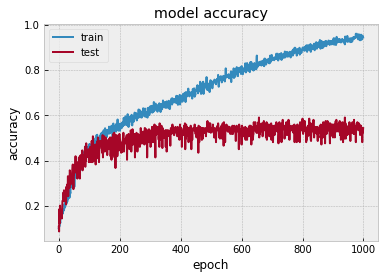

In [142]:
plt.plot(cnnhistory.history['acc'])
plt.plot(cnnhistory.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [143]:
from keras.models import load_model
saved_model = load_model('/Users/vaibhavverdhan/Capabilities/Speech-Emotion-Analyzer-master/weights.best.hdf5')

In [144]:
saved_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
score = saved_model.evaluate(x_testcnn, y_test, verbose=0)
print("%s: %.2f%%" % (saved_model.metrics_names[1], score[1]*100))

acc: 59.07%


## Predicting emotions on the test data

In [145]:
preds = saved_model.predict(x_testcnn, 
                         batch_size=32, 
                         verbose=1)

193/193 [==============================] - 0s 909us/step


In [146]:
preds

array([[1.15049414e-04, 6.04282104e-05, 1.50530056e-07, ...,
        2.14600533e-01, 3.02711427e-01, 4.24472034e-01],
       [2.45648134e-03, 7.56412923e-01, 5.23400269e-02, ...,
        1.77279684e-08, 1.59404578e-06, 2.46293552e-04],
       [8.37210412e-10, 1.42747159e-09, 1.12726029e-09, ...,
        9.66953188e-02, 3.43618244e-01, 1.30585566e-01],
       ...,
       [1.32991165e-08, 3.94232629e-08, 2.67638924e-08, ...,
        4.01755512e-01, 3.02501558e-03, 1.92716043e-03],
       [5.59429682e-05, 1.06013031e-03, 3.99300782e-03, ...,
        1.54418262e-06, 2.73712772e-06, 1.34273296e-06],
       [9.70554082e-10, 5.84059962e-05, 2.44432681e-06, ...,
        2.08710600e-02, 3.80075024e-03, 7.16493070e-01]], dtype=float32)

In [147]:
preds1=preds.argmax(axis=1)

In [148]:
preds1

array([9, 1, 5, 5, 1, 4, 0, 7, 4, 5, 9, 7, 1, 1, 7, 3, 7, 6, 0, 2, 8, 6,
       8, 6, 8, 4, 2, 6, 0, 0, 6, 0, 0, 6, 0, 6, 7, 2, 9, 5, 5, 9, 3, 0,
       9, 8, 2, 1, 7, 1, 6, 8, 6, 7, 6, 4, 4, 9, 8, 7, 0, 4, 0, 8, 5, 1,
       5, 8, 2, 2, 7, 1, 4, 8, 1, 7, 2, 9, 4, 0, 2, 0, 5, 5, 2, 3, 1, 9,
       6, 0, 7, 2, 7, 1, 8, 3, 3, 4, 4, 2, 7, 1, 8, 7, 5, 6, 4, 4, 9, 1,
       0, 8, 3, 4, 7, 4, 1, 5, 2, 2, 6, 1, 8, 0, 5, 2, 6, 7, 6, 1, 6, 4,
       6, 7, 5, 3, 4, 0, 6, 5, 6, 6, 8, 5, 5, 2, 6, 3, 8, 6, 6, 4, 0, 0,
       2, 4, 7, 4, 3, 2, 2, 2, 0, 7, 0, 5, 8, 9, 9, 7, 9, 4, 3, 5, 0, 4,
       9, 0, 4, 3, 5, 0, 6, 1, 0, 0, 7, 8, 1, 6, 5, 3, 9])

In [149]:
abc = preds1.astype(int).flatten()

In [150]:
predictions = (lb.inverse_transform((abc)))

In [151]:
preddf = pd.DataFrame({'predictedvalues': predictions})
preddf[:10]

,predictedvalues
0,male_sad
1,female_calm
2,male_angry
3,male_angry
4,female_calm
5,female_sad
6,female_angry
7,male_fearful
8,female_sad
9,male_angry


In [152]:
actual=y_test.argmax(axis=1)
abc123 = actual.astype(int).flatten()
actualvalues = (lb.inverse_transform((abc123)))

In [153]:
actualdf = pd.DataFrame({'actualvalues': actualvalues})
actualdf[:10]

,actualvalues
0,male_calm
1,female_fearful
2,male_fearful
3,male_calm
4,female_calm
5,female_sad
6,female_fearful
7,male_angry
8,female_sad
9,male_angry


In [154]:
finaldf = actualdf.join(preddf)

## Actual v/s Predicted emotions

In [155]:
finaldf[170:180]

,actualvalues,predictedvalues
170,male_sad,male_sad
171,female_happy,female_sad
172,female_angry,female_happy
173,male_fearful,male_angry
174,female_angry,female_angry
175,female_sad,female_sad
176,male_happy,male_sad
177,female_fearful,female_angry
178,female_calm,female_sad
179,female_fearful,female_happy


In [156]:
finaldf.groupby('actualvalues').count()

,predictedvalues
actualvalues,
female_angry,23
female_calm,18
female_fearful,21
female_happy,15
female_sad,18
male_angry,22
male_calm,22
male_fearful,21
male_happy,18


In [157]:
finaldf.groupby('predictedvalues').count()

,actualvalues
predictedvalues,
female_angry,25
female_calm,18
female_fearful,19
female_happy,12
female_sad,22
male_angry,20
male_calm,25
male_fearful,21
male_happy,17


In [65]:
finaldf.to_csv('Predictions.csv', index=False)